# Secondary implementation:
# Pre-trained DistilBERT model

***
## 1. Setting up the environment

In [1]:

# Model and training
import torch
from torch import cuda
import torch.nn as nn
from transformers import DistilBertForSequenceClassification
from transformers import AutoConfig


#from tqdm import tqdm
#from transformers import AdamW, get_linear_schedule_with_warmup
#import gc 

import nbimporter
from LSTM_GloVE import kaggle_toxic_preprocess, tokenized_toxic_dataloader, \
            optimizer_methods, epoch_loop, save_model, visualize_evaluation




In [2]:
device = 'cuda' if cuda.is_available() else 'cpu'

## 2. Preprocessing data

In [3]:
# Parameters for reading in the csv and separating the dataset
preprocess_params = {
    'csv_name':'input/jigsaw-toxic-comment-classification-challenge/train.csv.zip',
    'test_size': 0.4,
    'rows': 0,
    'negative_percent_drop': 0.97,
}

In [4]:
x_train , x_val , y_train , y_val = kaggle_toxic_preprocess(**preprocess_params)

## 3.Dataset and DataLoader

In [5]:
# Parameters of the tokenizer and it's config
token_vars = {
    'tokenizer': 'DistilBertTokenizer',
    'configname' : 'distilbert-base-uncased',
    'tokenizer_params': {
        'add_special_tokens' : True,
        'padding':'max_length',
        'return_tensors':'pt',
        'max_length': 200,
        'truncation':True,
    },
    'enc_type': torch.LongTensor,
    'device' : device,
}

In [6]:
# Parameters of the DataLoader
loader_vars = {
    'batch_size': 4,
    'num_workers': 0,
}

In [7]:
# Main configuration for the DataSets and DataLoaders
data_config = {
    'tokenizer_config': token_vars,
    'loader_config': loader_vars,
}

In [8]:
training_loader = tokenized_toxic_dataloader(x_train, y_train, **data_config)
test_loader = tokenized_toxic_dataloader(x_val, y_val, **data_config)

## 4. Model

In [9]:
class DistilBERTClass(nn.Module):
    def __init__(self, config):
        super(DistilBERTClass, self).__init__()
        self.bert = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', config=config)
        self.dropout = nn.Dropout(0.2)
        self.activation = nn.Sigmoid()

    def forward(self, inputs, _):
        bert_output = self.bert(inputs)
        dropped = self.dropout(bert_output[0])
        output = self.activation(dropped)
        return output

In [10]:
config = AutoConfig.from_pretrained('distilbert-base-uncased', num_labels=6, output_hidden_states=True)
model = DistilBERTClass(config).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classi

## 5. Optimization methods

In [11]:
optim_config = {
    'loss_fn_weights' : [1,10,4,11,5,15],
    'scheduler_params': {
        'base_lr' : 1e-5,
        'stop_factor_lr' : 1e-5,
        'factor' : 1,
    },
    'device' : device,
    'model_params': model.parameters(),
}

In [12]:
loss_fn, optimizer, scheduler = optimizer_methods(**optim_config)

## 6. Training loop

In [13]:
loss, accuracy, f1, predictions, truth = epoch_loop(
          model, 20, device,
          training_loader, test_loader, optimizer, scheduler, loss_fn,
          loader_vars['batch_size'],
          token_vars['tokenizer_params']['max_length'])

1it [00:02,  2.35s/it]

Layer (type:depth-idx)                             Kernel Shape     Output Shape     Param #          Mult-Adds
DistilBertForSequenceClassification: 1-1           --               [-1, 6]          --               --
DistilBertModel: 2-1                               --               [-1, 200, 768]   --               --
Embeddings: 3-1                                    --               [-1, 200, 768]   --               --
Embedding: 4-1                                     [768, 30522]     [-1, 200, 768]   23,440,896       23,440,896
Embedding: 4-2                                     [768, 512]       [-1, 200, 768]   393,216          393,216
LayerNorm: 4-3                                     [768]            [-1, 200, 768]   1,536            768
Dropout: 4-4                                       --               [-1, 200, 768]   --               --
Transformer: 3-2                                   --               [-1, 200, 768]   --               --
Linear: 2-2                       

401it [01:23,  4.83it/s]

tensor([[0.8454, 0.1111, 0.8907, 0.0288, 0.8939, 0.0919],
        [0.5000, 0.1388, 0.8799, 0.5000, 0.8725, 0.0820],
        [0.8340, 0.5000, 0.9193, 0.0335, 0.9058, 0.0940],
        [0.8780, 0.5000, 0.9209, 0.0330, 0.5000, 0.0798]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor(1.4831, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:26,  4.91it/s]
C:\Users\natan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(
2it [00:00, 14.80it/s]

0 epoch Training loss: 1.052 correct: 79.22 f1_score: 0.451


404it [00:25, 15.95it/s]

tensor([[0.9901, 0.0745, 0.9661, 0.0045, 0.9753, 0.0243],
        [0.9090, 0.0361, 0.1710, 0.0333, 0.5891, 0.9176],
        [0.9856, 0.4983, 0.9607, 0.0355, 0.9758, 0.9702],
        [0.5380, 0.0034, 0.0111, 0.0044, 0.1047, 0.0291]], device='cuda:0',
       grad_fn=<SigmoidBackward>)
tensor(0.9825, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:10, 15.78it/s]
0it [00:00, ?it/s]

0 epoch Validating loss: 0.975 correct: 85.41 f1_score: 0.551


401it [01:21,  4.92it/s]

tensor([[5.0000e-01, 7.8736e-03, 9.6724e-01, 6.4394e-04, 9.8912e-01, 5.0000e-01],
        [9.4710e-01, 5.1514e-04, 9.0708e-02, 5.9082e-04, 5.0000e-01, 4.8634e-03],
        [6.0012e-02, 1.2321e-03, 3.1589e-03, 1.0107e-03, 9.8165e-03, 1.8789e-02],
        [5.0000e-01, 7.9389e-01, 9.9810e-01, 4.3957e-03, 9.9836e-01, 4.5209e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8278, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 13.99it/s]

1 epoch Training loss: 1.001 correct: 83.17 f1_score: 0.489


404it [00:25, 15.80it/s]

tensor([[9.7660e-01, 2.1214e-03, 7.9107e-01, 3.0859e-04, 4.7584e-01, 1.3868e-03],
        [9.9850e-01, 1.2922e-02, 9.0950e-01, 7.8660e-04, 9.7752e-01, 6.2728e-03],
        [1.8009e-01, 6.4113e-04, 3.6890e-03, 3.9108e-04, 7.9406e-03, 3.4533e-03],
        [9.9810e-01, 5.6281e-02, 9.9387e-01, 9.6111e-04, 9.8691e-01, 3.6792e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.0867, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 15.98it/s]
0it [00:00, ?it/s]

1 epoch Validating loss: 0.961 correct: 86.53 f1_score: 0.589


401it [01:21,  4.90it/s]

tensor([[9.9898e-01, 1.3472e-03, 6.8444e-01, 1.7246e-04, 9.6696e-01, 9.3336e-04],
        [9.7333e-01, 5.0579e-05, 1.4817e-03, 3.5818e-05, 1.1270e-01, 5.0000e-01],
        [5.0000e-01, 4.4804e-02, 5.0000e-01, 2.3459e-03, 9.9357e-01, 5.0000e-01],
        [9.9947e-01, 5.3532e-03, 9.9797e-01, 5.0000e-01, 9.6960e-01, 5.5389e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.0749, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 15.19it/s]

2 epoch Training loss: 0.991 correct: 84.15 f1_score: 0.508


402it [00:25, 15.62it/s]

tensor([[9.9864e-01, 9.9531e-01, 9.9930e-01, 1.2393e-02, 9.9902e-01, 4.2693e-01],
        [2.2911e-01, 5.5411e-04, 4.2298e-03, 3.1232e-04, 2.3744e-03, 2.0917e-02],
        [9.6642e-01, 1.2349e-03, 9.1811e-01, 1.1699e-04, 8.6667e-02, 1.3376e-03],
        [9.9675e-01, 1.4125e-04, 3.7438e-02, 4.6838e-05, 3.2463e-01, 1.2798e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8609, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 15.99it/s]
0it [00:00, ?it/s]

2 epoch Validating loss: 0.957 correct: 86.97 f1_score: 0.580


401it [01:21,  4.97it/s]

tensor([[9.9969e-01, 5.0000e-01, 9.9988e-01, 4.8894e-03, 9.9970e-01, 2.6042e-02],
        [9.9981e-01, 5.0000e-01, 5.0000e-01, 2.0684e-05, 9.1656e-01, 5.0000e-01],
        [5.0000e-01, 5.0000e-01, 9.9796e-01, 5.0000e-01, 5.0000e-01, 9.9877e-01],
        [6.4826e-03, 5.0000e-01, 8.5798e-04, 3.7631e-05, 2.5192e-04, 5.0000e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.2472, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 15.52it/s]

3 epoch Training loss: 0.983 correct: 85.12 f1_score: 0.523


404it [00:25, 15.72it/s]

tensor([[7.3428e-03, 4.8452e-04, 3.2854e-03, 1.1174e-04, 4.7182e-04, 5.3414e-03],
        [9.9972e-01, 9.9049e-01, 9.9960e-01, 3.1402e-03, 9.9929e-01, 1.6170e-02],
        [4.3898e-02, 3.6884e-04, 4.4179e-03, 9.1557e-05, 8.0591e-04, 6.4171e-03],
        [9.9998e-01, 1.3328e-02, 9.9801e-01, 7.2358e-05, 9.9830e-01, 1.0554e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8800, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 15.99it/s]
0it [00:00, ?it/s]

3 epoch Validating loss: 0.958 correct: 85.40 f1_score: 0.606


401it [01:21,  4.93it/s]

tensor([[9.9992e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 3.3865e-04],
        [3.2145e-03, 5.0000e-01, 7.9661e-04, 1.1241e-05, 9.0310e-05, 5.0000e-01],
        [9.9948e-01, 2.6663e-05, 6.2781e-04, 5.4660e-06, 4.6119e-02, 5.0000e-01],
        [9.5422e-04, 1.3637e-04, 1.6262e-03, 1.6575e-05, 1.6999e-04, 2.7310e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7445, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 17.04it/s]

4 epoch Training loss: 0.978 correct: 85.81 f1_score: 0.533


404it [00:25, 16.20it/s]

tensor([[9.9634e-01, 2.6880e-05, 4.6427e-02, 1.4947e-06, 5.8857e-03, 3.8316e-04],
        [9.9957e-01, 9.5886e-01, 9.9812e-01, 1.4228e-02, 9.9787e-01, 9.9868e-01],
        [9.9999e-01, 3.9830e-03, 9.9965e-01, 1.2834e-05, 9.9797e-01, 2.4736e-03],
        [8.9342e-01, 3.2500e-03, 9.8294e-01, 7.6945e-05, 6.9467e-03, 2.0709e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.9974, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.00it/s]
0it [00:00, ?it/s]

4 epoch Validating loss: 0.957 correct: 88.00 f1_score: 0.609


401it [01:21,  4.89it/s]

tensor([[9.9992e-01, 5.0000e-01, 5.0000e-01, 2.9112e-03, 9.9943e-01, 5.0000e-01],
        [1.0000e+00, 8.4546e-03, 5.0000e-01, 5.0000e-01, 9.9975e-01, 2.1667e-03],
        [5.0000e-01, 2.5761e-06, 2.4371e-04, 5.0000e-01, 7.4616e-04, 2.2860e-04],
        [9.9767e-01, 2.1173e-04, 9.9721e-01, 8.9244e-07, 6.9190e-03, 2.3569e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.0373, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 16.34it/s]

5 epoch Training loss: 0.973 correct: 86.54 f1_score: 0.544


404it [00:25, 15.68it/s]

tensor([[2.5348e-01, 5.1337e-05, 1.5075e-02, 2.1408e-06, 1.0617e-04, 4.8513e-04],
        [9.9992e-01, 5.3186e-04, 3.6800e-02, 2.0061e-04, 9.9008e-01, 9.7437e-01],
        [1.0000e+00, 1.4608e-03, 9.9801e-01, 1.4724e-05, 9.9937e-01, 1.1871e-02],
        [9.9998e-01, 3.1024e-02, 9.8853e-01, 6.8686e-04, 9.9963e-01, 9.9680e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.9832, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.01it/s]
0it [00:00, ?it/s]

5 epoch Validating loss: 0.952 correct: 87.84 f1_score: 0.628


401it [01:21,  4.96it/s]

tensor([[1.0000e+00, 1.1919e-02, 9.9885e-01, 5.1321e-06, 9.9999e-01, 2.1122e-04],
        [1.0000e+00, 3.5010e-02, 9.9998e-01, 1.1194e-05, 9.9996e-01, 7.8096e-04],
        [5.0000e-01, 5.8683e-05, 9.9964e-01, 1.8541e-07, 7.6860e-02, 2.2950e-04],
        [6.1157e-03, 8.9857e-06, 1.5153e-04, 2.2416e-07, 1.6931e-05, 1.8806e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8002, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 16.06it/s]

6 epoch Training loss: 0.969 correct: 86.85 f1_score: 0.551


404it [00:25, 16.20it/s]

tensor([[9.9998e-01, 3.7317e-03, 9.9894e-01, 1.7372e-05, 9.7403e-01, 1.0488e-03],
        [9.9996e-01, 4.1795e-05, 9.2321e-04, 4.0154e-06, 8.9230e-01, 1.8720e-03],
        [9.9972e-01, 9.9863e-01, 9.9927e-01, 2.3228e-02, 9.9894e-01, 6.2956e-02],
        [9.8379e-01, 3.1300e-04, 9.8483e-01, 5.5469e-06, 1.8487e-03, 2.3882e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8912, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.01it/s]
0it [00:00, ?it/s]

6 epoch Validating loss: 0.955 correct: 88.39 f1_score: 0.619


401it [01:21,  4.85it/s]

tensor([[1.7051e-03, 6.8264e-05, 5.1615e-03, 9.1346e-06, 8.7052e-05, 1.9633e-03],
        [5.0000e-01, 5.0000e-01, 2.9408e-05, 5.6373e-08, 6.5171e-03, 5.0000e-01],
        [9.9981e-01, 6.8798e-07, 5.0000e-01, 1.8456e-08, 1.5009e-02, 1.8952e-05],
        [1.1589e-03, 1.0444e-05, 1.2760e-03, 3.0306e-07, 1.8269e-05, 3.4948e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8396, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 16.44it/s]

7 epoch Training loss: 0.965 correct: 87.25 f1_score: 0.554


404it [00:25, 15.31it/s]

tensor([[9.9999e-01, 1.1938e-04, 9.9981e-01, 5.8801e-07, 7.4983e-01, 4.7172e-04],
        [9.9999e-01, 3.1159e-01, 9.9943e-01, 3.3469e-03, 9.9973e-01, 9.9936e-01],
        [5.3697e-02, 1.1198e-05, 1.1672e-03, 3.3719e-07, 3.6110e-05, 3.6823e-04],
        [9.9989e-01, 2.3815e-05, 2.5853e-04, 1.3260e-06, 5.4470e-01, 7.2882e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8193, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.00it/s]
0it [00:00, ?it/s]

7 epoch Validating loss: 0.954 correct: 88.86 f1_score: 0.633


401it [01:21,  4.91it/s]

tensor([[1.0000e+00, 2.6575e-05, 9.9998e-01, 2.5417e-08, 9.9718e-01, 8.6440e-05],
        [3.2008e-04, 5.2264e-05, 5.0000e-01, 1.0456e-05, 1.4417e-04, 2.2877e-03],
        [2.0709e-03, 3.6177e-05, 1.3828e-03, 1.2665e-06, 2.3369e-05, 3.9868e-04],
        [5.0000e-01, 3.1914e-05, 7.2827e-04, 2.7969e-06, 7.7738e-05, 1.1911e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7608, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 14.97it/s]

8 epoch Training loss: 0.961 correct: 87.58 f1_score: 0.563


402it [00:25, 16.07it/s]

tensor([[1.0000e+00, 1.0754e-05, 7.0101e-01, 1.4426e-07, 9.8119e-01, 1.6870e-04],
        [1.0000e+00, 2.8768e-04, 2.9453e-01, 1.8930e-05, 9.9991e-01, 7.6784e-03],
        [9.9984e-01, 1.6711e-04, 9.9979e-01, 7.3948e-07, 2.6533e-02, 7.6656e-04],
        [6.2560e-01, 2.5349e-06, 2.2841e-03, 3.4427e-08, 1.8219e-05, 1.9173e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8566, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.02it/s]
1it [00:00,  5.09it/s]

8 epoch Validating loss: 0.954 correct: 88.39 f1_score: 0.620


401it [01:21,  4.94it/s]

tensor([[9.8508e-01, 5.0000e-01, 1.1381e-05, 5.0000e-01, 1.1018e-04, 1.0810e-04],
        [5.0000e-01, 9.9944e-01, 9.9988e-01, 6.7924e-02, 5.0000e-01, 3.7352e-03],
        [5.0000e-01, 5.0000e-01, 9.9993e-01, 4.0475e-08, 3.6017e-03, 2.7459e-04],
        [9.9979e-01, 2.3244e-05, 5.9007e-06, 2.5819e-06, 5.9876e-01, 5.0000e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8687, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 14.96it/s]

9 epoch Training loss: 0.954 correct: 88.17 f1_score: 0.570


404it [00:25, 16.17it/s]

tensor([[9.9999e-01, 9.7165e-01, 9.9972e-01, 7.8576e-02, 9.9988e-01, 9.9976e-01],
        [9.8895e-01, 3.0398e-06, 1.8115e-04, 7.4553e-08, 3.1962e-05, 7.5505e-04],
        [2.3235e-01, 2.6582e-06, 1.4797e-04, 1.1576e-07, 1.5534e-05, 2.6694e-04],
        [3.4117e-03, 1.4924e-05, 2.4210e-04, 1.5027e-06, 4.7991e-05, 5.1988e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.0316, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.01it/s]
0it [00:00, ?it/s]

9 epoch Validating loss: 0.949 correct: 88.33 f1_score: 0.635


401it [01:21,  4.83it/s]

tensor([[1.0000e+00, 5.0000e-01, 5.0000e-01, 8.6940e-07, 1.0000e+00, 1.0185e-03],
        [1.5065e-04, 1.2103e-05, 3.0128e-04, 5.0000e-01, 4.4126e-05, 5.0000e-01],
        [1.0000e+00, 6.6763e-03, 1.0000e+00, 2.6356e-07, 9.9947e-01, 5.0000e-01],
        [5.0000e-01, 9.8586e-03, 9.9998e-01, 5.0000e-01, 1.0000e+00, 3.2879e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.9172, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 15.22it/s]

10 epoch Training loss: 0.952 correct: 88.25 f1_score: 0.576


402it [00:25, 16.21it/s]

tensor([[1.4751e-02, 3.5853e-06, 1.4597e-04, 4.8490e-07, 5.8610e-06, 3.5365e-04],
        [9.9358e-01, 8.0458e-07, 8.4946e-04, 4.9186e-08, 1.0979e-05, 1.8873e-03],
        [2.7632e-02, 2.5968e-06, 1.2349e-04, 2.6796e-07, 6.6106e-06, 2.0316e-04],
        [9.9994e-01, 3.1421e-05, 9.9846e-01, 1.5085e-07, 2.6493e-03, 1.9046e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7286, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.01it/s]
0it [00:00, ?it/s]

10 epoch Validating loss: 0.951 correct: 88.62 f1_score: 0.631


401it [01:21,  4.85it/s]

tensor([[1.0000e+00, 4.5156e-04, 1.0000e+00, 3.2766e-08, 9.9998e-01, 5.0000e-01],
        [7.1691e-04, 3.3731e-06, 1.2839e-04, 5.0000e-01, 7.1467e-06, 7.3278e-05],
        [9.7691e-01, 8.7928e-08, 3.3212e-05, 8.5684e-10, 1.3136e-06, 5.0000e-01],
        [1.0000e+00, 1.3840e-04, 5.0837e-01, 7.3870e-07, 1.0000e+00, 3.5399e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8268, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:25,  4.92it/s]
2it [00:00, 15.64it/s]

11 epoch Training loss: 0.949 correct: 88.60 f1_score: 0.578


402it [00:25, 15.99it/s]

tensor([[1.0000e+00, 1.5706e-06, 9.9095e-01, 4.1860e-08, 6.0833e-03, 1.1886e-03],
        [1.0000e+00, 1.4201e-06, 2.5200e-03, 4.6245e-07, 2.0470e-01, 7.5727e-04],
        [1.0000e+00, 1.2646e-05, 9.9990e-01, 1.5391e-07, 9.9680e-01, 2.6692e-03],
        [9.9997e-01, 1.5790e-06, 8.3114e-06, 1.3013e-06, 3.3284e-02, 9.0266e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8116, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 15.99it/s]
0it [00:00, ?it/s]

11 epoch Validating loss: 0.956 correct: 89.13 f1_score: 0.609


401it [01:21,  4.85it/s]

tensor([[5.0000e-01, 8.8170e-06, 2.9059e-04, 6.0394e-06, 1.9835e-05, 2.4239e-04],
        [1.0000e+00, 2.2013e-07, 8.6578e-07, 9.7753e-08, 5.0000e-01, 5.0000e-01],
        [1.0000e+00, 2.3601e-08, 5.0000e-01, 4.6756e-09, 5.0000e-01, 5.0000e-01],
        [1.0000e+00, 2.4609e-05, 9.9908e-01, 1.0274e-06, 9.9996e-01, 9.9995e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8015, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:26,  4.92it/s]
2it [00:00, 15.90it/s]

12 epoch Training loss: 0.947 correct: 88.58 f1_score: 0.577


404it [00:25, 15.51it/s]

tensor([[9.7362e-04, 1.9926e-05, 3.7101e-04, 4.2042e-05, 1.0127e-04, 1.7389e-03],
        [9.9799e-01, 2.3559e-05, 1.3633e-04, 1.1526e-04, 1.1396e-03, 9.6542e-01],
        [1.0000e+00, 9.9922e-01, 1.0000e+00, 1.3289e-03, 9.9997e-01, 4.7010e-03],
        [9.9948e-01, 5.3291e-05, 1.0474e-04, 6.9560e-04, 3.3000e-02, 4.1282e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.9466, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.00it/s]
0it [00:00, ?it/s]

12 epoch Validating loss: 0.948 correct: 88.21 f1_score: 0.626


401it [01:21,  4.89it/s]

tensor([[1.0000e+00, 2.0809e-06, 5.0000e-01, 5.9297e-08, 5.0000e-01, 1.2796e-03],
        [1.0000e+00, 5.0000e-01, 6.1520e-04, 5.0000e-01, 3.5380e-01, 6.7906e-05],
        [1.0000e+00, 5.0000e-01, 5.0000e-01, 4.4957e-05, 5.0000e-01, 5.0000e-01],
        [9.9991e-01, 1.0314e-06, 1.5071e-06, 1.0655e-05, 2.8504e-03, 5.0000e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.9365, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:26,  4.92it/s]
2it [00:00, 15.75it/s]

13 epoch Training loss: 0.943 correct: 89.00 f1_score: 0.583


404it [00:25, 15.92it/s]

tensor([[1.0000e+00, 9.4837e-07, 9.0304e-05, 3.0451e-06, 9.5550e-01, 1.9882e-04],
        [9.9998e-01, 2.9106e-06, 3.5015e-03, 1.4936e-05, 2.4344e-03, 6.9846e-04],
        [9.9993e-01, 1.5109e-05, 6.4735e-06, 1.0093e-04, 8.1393e-01, 1.4374e-03],
        [9.8240e-01, 3.6142e-06, 1.8728e-05, 3.1077e-05, 4.9618e-05, 7.4514e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.0193, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 15.97it/s]
0it [00:00, ?it/s]

13 epoch Validating loss: 0.951 correct: 89.03 f1_score: 0.633


401it [01:21,  4.91it/s]

tensor([[1.3552e-04, 2.2761e-07, 3.8143e-05, 1.1469e-06, 2.5023e-06, 6.7732e-05],
        [9.9948e-01, 4.5957e-08, 1.1574e-02, 5.0000e-01, 9.7171e-07, 5.0000e-01],
        [5.0000e-01, 1.1606e-05, 9.8867e-01, 4.8632e-08, 5.0000e-01, 3.2798e-05],
        [5.0000e-01, 6.5687e-06, 1.0000e+00, 6.9272e-09, 9.9983e-01, 5.0000e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8479, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:26,  4.91it/s]
2it [00:00, 15.04it/s]

14 epoch Training loss: 0.942 correct: 89.00 f1_score: 0.582


404it [00:25, 16.23it/s]

tensor([[6.1256e-04, 5.5974e-05, 6.8943e-04, 3.1651e-04, 5.1228e-04, 2.3443e-03],
        [1.0000e+00, 9.9921e-01, 1.0000e+00, 5.8407e-03, 9.9999e-01, 2.0351e-03],
        [1.0000e+00, 3.5569e-04, 9.9998e-01, 9.9363e-07, 9.9971e-01, 1.7385e-04],
        [1.0000e+00, 9.9708e-01, 1.0000e+00, 9.3855e-03, 9.9999e-01, 9.9967e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.1854, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.00it/s]
0it [00:00, ?it/s]

14 epoch Validating loss: 0.953 correct: 88.83 f1_score: 0.637


401it [01:21,  4.85it/s]

tensor([[9.9262e-01, 2.0209e-08, 8.9597e-07, 3.4038e-07, 5.0000e-01, 3.4221e-05],
        [1.0000e+00, 8.8946e-05, 1.0000e+00, 6.9650e-08, 2.7489e-01, 1.2547e-05],
        [1.0000e+00, 4.0959e-07, 9.5747e-04, 8.9461e-07, 9.9998e-01, 8.5412e-05],
        [5.0000e-01, 7.5654e-06, 2.0893e-05, 5.3283e-05, 5.0000e-01, 5.9599e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8086, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:26,  4.92it/s]
2it [00:00, 14.62it/s]

15 epoch Training loss: 0.942 correct: 89.20 f1_score: 0.586


404it [00:25, 16.19it/s]

tensor([[9.9998e-01, 9.3819e-07, 5.8888e-06, 2.4847e-05, 3.7160e-02, 8.7085e-01],
        [1.0000e+00, 3.4278e-04, 9.9992e-01, 4.0049e-06, 9.8792e-01, 9.1107e-04],
        [1.0000e+00, 6.5495e-05, 9.9998e-01, 4.1231e-07, 9.9997e-01, 1.2578e-03],
        [4.4830e-04, 8.6576e-05, 2.4546e-03, 2.7566e-04, 6.7428e-04, 2.0676e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.9564, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 15.99it/s]
0it [00:00, ?it/s]

15 epoch Validating loss: 0.948 correct: 88.32 f1_score: 0.624


401it [01:21,  4.93it/s]

tensor([[5.0000e-01, 9.9862e-01, 9.9344e-01, 9.9969e-01, 5.0000e-01, 5.3802e-03],
        [1.0000e+00, 9.9979e-01, 1.0000e+00, 7.4570e-05, 1.0000e+00, 5.0000e-01],
        [1.0000e+00, 5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 6.6148e-03],
        [5.0000e-01, 2.0281e-02, 4.2777e-03, 9.7918e-01, 5.8797e-03, 8.8908e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.2157, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:26,  4.92it/s]
2it [00:00, 15.56it/s]

16 epoch Training loss: 0.939 correct: 89.47 f1_score: 0.590


404it [00:25, 16.06it/s]

tensor([[9.9995e-01, 2.4919e-05, 9.9982e-01, 7.9021e-07, 1.0357e-03, 4.3155e-04],
        [4.3678e-04, 2.9753e-05, 8.2305e-04, 2.0807e-04, 2.4110e-04, 8.3504e-04],
        [1.0000e+00, 1.2181e-05, 5.0746e-03, 1.1255e-05, 9.9994e-01, 7.9090e-05],
        [9.9811e-01, 3.8198e-03, 1.4761e-03, 9.5028e-01, 1.9758e-02, 7.0300e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8087, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 15.99it/s]
0it [00:00, ?it/s]

16 epoch Validating loss: 0.949 correct: 88.38 f1_score: 0.635


401it [01:21,  4.94it/s]

tensor([[5.0000e-01, 5.0000e-01, 5.0000e-01, 5.0000e-01, 1.0000e+00, 3.7051e-05],
        [1.0000e+00, 5.0000e-01, 9.9994e-01, 5.6939e-07, 1.0000e+00, 3.7968e-05],
        [3.5637e-05, 5.0000e-01, 5.2627e-05, 3.1872e-05, 8.8353e-06, 1.1223e-04],
        [9.8984e-01, 5.0000e-01, 1.4726e-07, 2.5668e-05, 5.0000e-01, 5.0000e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8211, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:26,  4.92it/s]
2it [00:00, 14.97it/s]

17 epoch Training loss: 0.937 correct: 89.50 f1_score: 0.594


404it [00:25, 15.78it/s]

tensor([[1.0000e+00, 1.4359e-04, 9.9999e-01, 2.7933e-07, 9.9989e-01, 7.4749e-05],
        [1.0000e+00, 3.3051e-06, 9.9997e-01, 8.1599e-08, 1.1323e-02, 1.9272e-04],
        [9.9995e-01, 1.6577e-05, 9.9993e-01, 3.8304e-07, 1.2925e-03, 3.1825e-04],
        [9.9998e-01, 6.6123e-07, 8.6211e-01, 2.1050e-07, 2.3108e-05, 1.0485e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.1442, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 16.00it/s]
0it [00:00, ?it/s]

17 epoch Validating loss: 0.952 correct: 89.08 f1_score: 0.622


401it [01:21,  4.90it/s]

tensor([[9.8048e-05, 5.0000e-01, 1.5283e-04, 1.8902e-05, 2.6426e-05, 1.6173e-04],
        [1.0000e+00, 5.0000e-01, 9.9999e-01, 1.7087e-08, 1.0000e+00, 8.4132e-05],
        [5.0000e-01, 3.3295e-02, 1.0000e+00, 1.0688e-07, 9.9987e-01, 2.7860e-06],
        [9.9998e-01, 1.6260e-06, 9.9999e-01, 2.7913e-08, 1.9427e-04, 2.7799e-05]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.8218, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:26,  4.92it/s]
2it [00:00, 14.69it/s]

18 epoch Training loss: 0.936 correct: 89.78 f1_score: 0.597


404it [00:25, 16.04it/s]

tensor([[9.9999e-01, 6.4298e-08, 4.9717e-06, 3.7558e-06, 9.4353e-05, 1.2605e-04],
        [9.9998e-01, 7.2461e-07, 3.0411e-06, 1.4601e-04, 1.4475e-03, 1.5745e-04],
        [1.0000e+00, 2.3912e-05, 9.9284e-02, 5.6837e-04, 9.9784e-01, 9.9994e-01],
        [9.9969e-01, 2.7271e-07, 2.9874e-06, 1.5561e-05, 1.5985e-05, 8.1072e-03]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7362, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 15.99it/s]
0it [00:00, ?it/s]

18 epoch Validating loss: 0.948 correct: 88.21 f1_score: 0.625


401it [01:21,  4.90it/s]

tensor([[1.0000e+00, 1.0276e-10, 1.6923e-07, 1.2963e-08, 3.2140e-05, 1.1162e-03],
        [5.0000e-01, 2.0582e-06, 9.9999e-01, 1.9229e-08, 1.0000e+00, 1.7163e-05],
        [5.0000e-01, 6.8128e-10, 2.5160e-06, 2.6500e-08, 2.9901e-06, 3.6865e-06],
        [1.0000e+00, 2.9151e-08, 1.6063e-06, 6.5322e-07, 9.0353e-01, 5.0000e-01]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(0.7376, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


3079it [10:26,  4.92it/s]
2it [00:00, 15.04it/s]

19 epoch Training loss: 0.935 correct: 89.79 f1_score: 0.597


404it [00:25, 16.22it/s]

tensor([[1.0000e+00, 3.6082e-06, 1.8162e-02, 2.0467e-05, 9.9999e-01, 4.9106e-04],
        [1.0000e+00, 5.6288e-06, 9.3651e-01, 4.1078e-06, 1.0000e+00, 5.6975e-04],
        [1.0000e+00, 9.9941e-01, 1.0000e+00, 8.5718e-04, 9.9999e-01, 1.0129e-03],
        [1.0000e+00, 2.0448e-07, 1.8117e-06, 1.3368e-05, 1.4442e-01, 5.2740e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward>)
tensor(1.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


2053it [02:08, 15.99it/s]

19 epoch Validating loss: 0.949 correct: 88.73 f1_score: 0.628


## 7. Evaluation

C:\Users\natan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\natan\AppData\Roaming\Python\Python38\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

        Toxic       0.84      0.92      0.88    280547
 Severe toxic       0.72      0.42      0.53     54752
      Obscene       0.83      0.80      0.81    174462
       Threat       0.30      0.48      0.37      5922
       Insult       0.82      0.68      0.74    188078
Identity hate       0.76      0.45      0.57     46777

    micro avg       0.82      0.76      0.79    750538
    macro avg       0.71      0.63      0.65    750538
 weighted avg       0.81      0.76      0.78    750538
  samples avg       0.63      0.58      0.58    750538



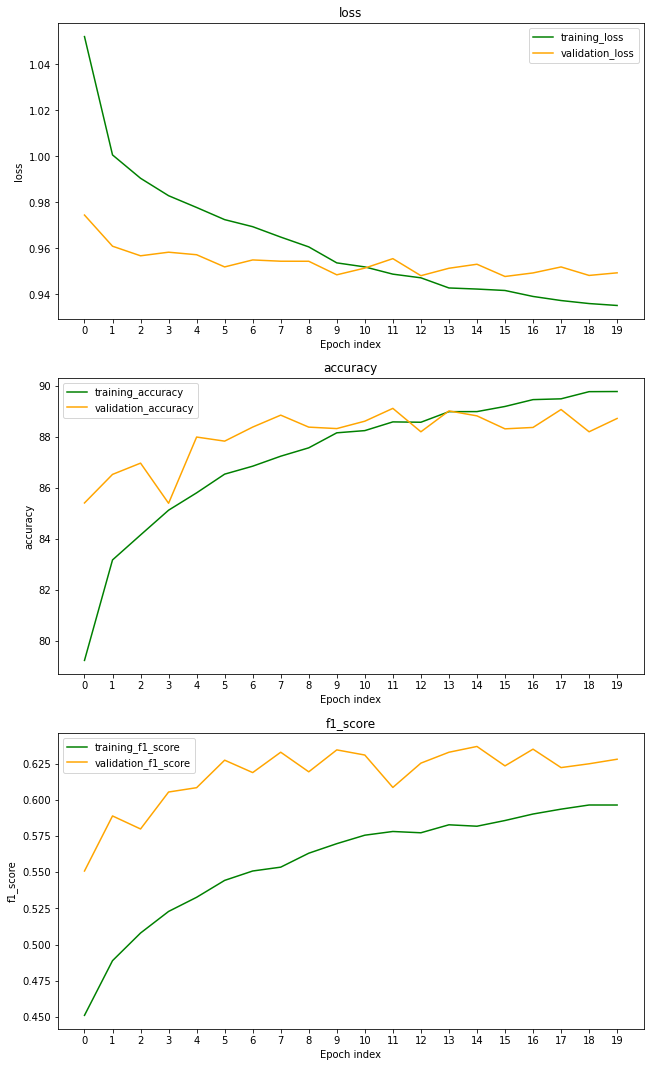

In [14]:
visualize_evaluation([
    (loss, 'loss'),
    (accuracy, 'accuracy'),
    (f1, 'f1_score'),],
    predictions,
    truth,
)

## 8. Save the model

In [15]:
save_model('bert', model)